# Лабораторная работа №3.
## Многослойные сети. Алгоритм обратного распространения ошибки.
### Выполнила: Михеева Кристина Олеговна
#### Группа М8О-407Б-20
##### Вариант: 15

## Цель работы

Целью работы является исследование свойств многослойной нейронной сети прямого распространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции.


## Ход работы

## Задание 1
Использовать многослойную нейронную сеть для классификации точек в случае, когда
классы не являются линейно разделимыми.

Для начала извлечем некоторые библиотеки, которые помогут нам в выполнении данной работы. Для построение графика нам понадобится библиотека - *matplotlib*, для выполнение операций с массивами мы подключим - *numpy*, а также библиотеку для обучния нейронных сетей - *torch*

In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

from itertools import product


Запишем параметры в словари трех алгебраических линий. У меня варианте предствлены два эллипса и одна парабола.

In [2]:
ellipse1 = dict(
    a = 0.4,  #большая полуось эллипса
    b = 0.15, #большая полуось эллипса
    alpha = np.pi/6, #угол пороврота
    x0 = 0, #координата параллельного переноса по х0
    y0 = 0  #координата параллельного переноса по у0
)

ellipse2 = dict(
    a = 0.7,
    b = 0.5,
    alpha = np.pi/3,
    x0 = 0,
    y0 = 0
)

parabola_params = dict(
    p = 1,  #параметр параболы
    alpha = np.pi/2,
    x0 = 0,
    y0 = -0.8
)

t_el = np.linspace(0, 2*np.pi, int(2*np.pi/0.025)) #параметр генерации точек для параметрического уравнения линии в канонической с истеме координат для эллипсов
t_pr = np.linspace(-1, 1, int(2/0.025)) #параметр генерации точек для параметрического уравнения линии в канонической с истеме координат для параболы

Генерируем точки алгебраических линий с помощью параметричечких уравнений в канонической системе координат.

In [3]:
# Уравнение эллипса в параметрическом виде.
def ellipse(a, b, alpha,  x0, y0):
    t = np.linspace(0, 2*np.pi, int(2*np.pi/0.025))
    x = a * np.cos(t) * np.cos(alpha) - b * np.sin(t) * np.sin(alpha) + x0
    y = a * np.cos(t) * np.sin(alpha) + b * np.sin(t) * np.cos(alpha) + y0
    return x, y

# Уравнение параболы в параметрическом виде.
def parabola(p, alpha, x0, y0):
  t = np.linspace(-1, 1, int(2/0.025))
  x = (t**2/(2*p)) * np.cos(alpha) - t*np.sin(alpha) + x0
  y = (t**2/(2*p)) * np.sin(alpha) + t*np.cos(alpha) + y0
  return x, y


Выведим как изначально построились точки с выборкой 60, 100, 120 для трех классов соотвесвенно.

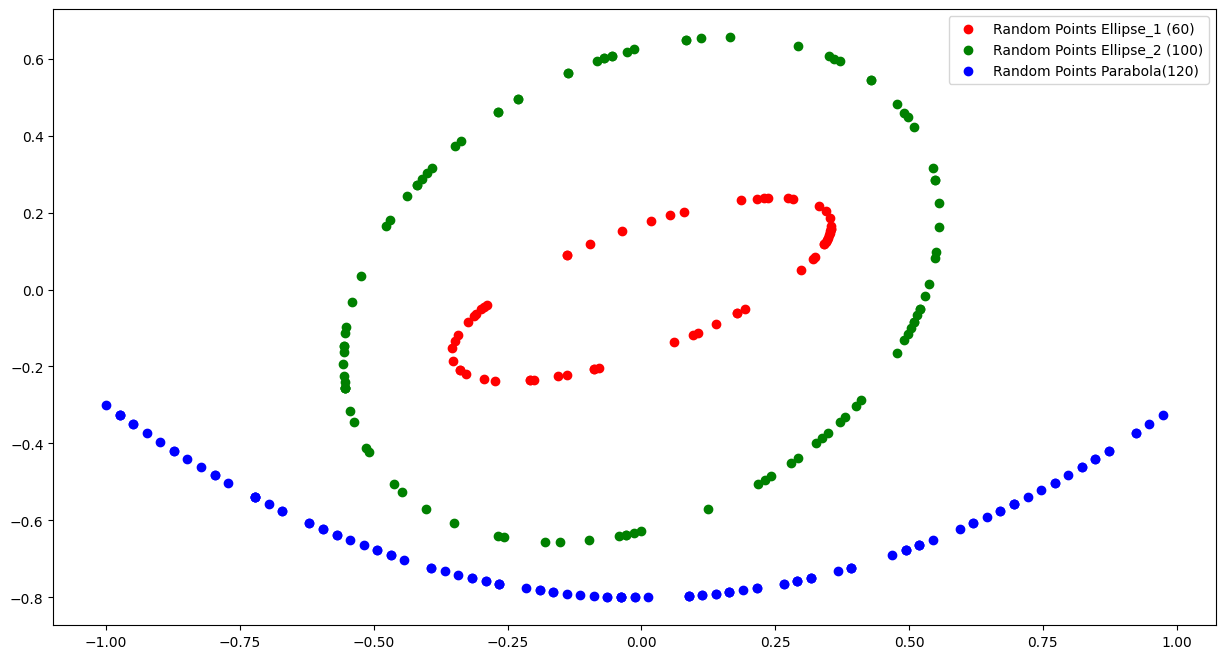

In [4]:
figure = plt.figure(figsize=(15, 8))

# Генерация 60 случайных точек на графике ellipse1
el1_x, el1_y = ellipse(ellipse1["a"], ellipse1["b"], ellipse1["alpha"], ellipse1["x0"], ellipse1["y0"])
random_indices_el1 = np.random.choice(len(t_el), 60)
random_x_el1, random_y_el1  = el1_x[random_indices_el1], el1_y[random_indices_el1]
plt.scatter(random_x_el1, random_y_el1, c='r', label='Random Points Ellipse_1 (60)', marker='o')

# Генерация 100 случайных точек на графике ellipse2
el2_x, el2_y = ellipse(ellipse2["a"], ellipse2["b"], ellipse2["alpha"], ellipse2["x0"], ellipse2["y0"])
random_indices_el2 = np.random.choice(len(t_el), 100)
random_x_el2,random_y_el2 = el2_x[random_indices_el2],el2_y[random_indices_el2]
plt.scatter(random_x_el2, random_y_el2, c='g', label='Random Points Ellipse_2 (100)', marker='o')

#Генерация 120 случайных точек на графике parabola
pr_x, pr_y = parabola(parabola_params['p'], parabola_params['alpha'], parabola_params['x0'], parabola_params['y0'])
random_indices_pr = np.random.choice(len(t_pr), 120)
random_x_pr, random_y_pr = pr_x[random_indices_pr], pr_y[random_indices_pr]
plt.scatter(random_x_pr, random_y_pr, c='b', label='Random Points Parabola(120)', marker='o')

plt.legend()
plt.show()

Разабьем данные на тренировачные(70%), контрольные(20%) и тестовые(10%) знакчения.

In [5]:
# Списки данных и меток для каждой из трех частей
X = [np.vstack((random_x_el1, random_y_el1)).T, np.vstack((random_x_el2, random_y_el2)).T, np.vstack((random_x_pr, random_y_pr)).T]
Y = [np.zeros(shape=(60,)), np.ones(shape=(100,)), 2 * np.ones(shape=(120,))]

X_train, X_val, X_test, Y_train, Y_val, Y_test = [], [], [], [], [], []

# Проходим по каждой части данных
for x, y in zip(X, Y):
    X_tr, X_te, Y_tr, Y_te = train_test_split(x, y, test_size=0.3, random_state=20)
    X_v, X_te, Y_v, Y_te = train_test_split(X_te, Y_te, test_size=0.33, random_state=76)

    X_train.append(X_tr)
    X_val.append(X_v)
    X_test.append(X_te)
    Y_train.append(Y_tr)
    Y_val.append(Y_v)
    Y_test.append(Y_te)

# Объединяем все части данных
X_train = np.vstack(X_train)
Y_train = np.concatenate(Y_train)
X_val = np.vstack(X_val)
Y_val = np.concatenate(Y_val)
X_test = np.vstack(X_test)
Y_test = np.concatenate(Y_test)


Класс __data__ создает пользовательский набор данных для использования. Он конвертирует переданные массивы данных и меток в тензоры PyTorch и предоставляет методы __len__ для получения длины набора данных и __getitem__ для доступа к данным и меткам по индексу. Этот класс упрощает работу с данными при обучении моделей машинного обучения в PyTorch.

In [6]:
class data(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx]

Получим три загрузчика данных: train_loader для обучения, val_loader для валидации и test_loader для тестирования.

In [7]:
train_loader = DataLoader(dataset=data(X_train, Y_train), shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=data(X_val, Y_val), batch_size=32)
test_loader = DataLoader(dataset=data(X_test, Y_test), batch_size=1)

Создадим многослойную обучающую модель.

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 20)
        self.act = nn.ReLU()
        self.output = nn.Linear(20, 3)

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(self.act(x))
        return x

In [14]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [15]:
epochs = 1500
losses = []
total_correct = 0

for epoch in range(epochs):
    for data, labels in train_loader:
        loss = criterion(model(data), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    for data, labels in val_loader:
        Y_pred = torch.argmax(model(data), dim=1)
        is_correct = (Y_pred == labels)
        total_correct += is_correct.sum()

    Y_pred = []
    for data, labels in test_loader:
      Y_pred.append(np.argmax(torch.squeeze(model(data), dim=0).tolist()))

In [16]:
losses[-1]

0.1929435431957245

Построим графики с истинными и предсказанными метками.

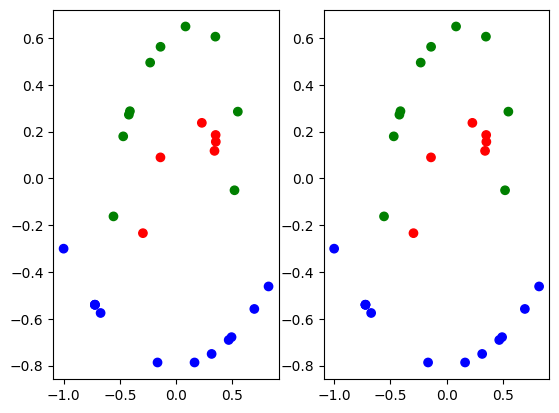

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# График с истинными метками (Y_test)
colors_true = []
for val in Y_test:
    if val == 0:
        colors_true.append('red')
    elif val == 1:
        colors_true.append('green')
    else:
        colors_true.append('blue')
ax1.scatter(X_test[:, 0], X_test[:, 1], color=colors_true)

# График с предсказанными метками (Y_pred)
colors_pred = []
for val in Y_pred:
    if val == 0:
        colors_pred.append('red')
    elif val == 1:
        colors_pred.append('green')
    else:
        colors_pred.append('blue')
ax2.scatter(X_test[:, 0], X_test[:, 1], color=colors_true)

plt.show()


Построим на классификацию точек во всей области.

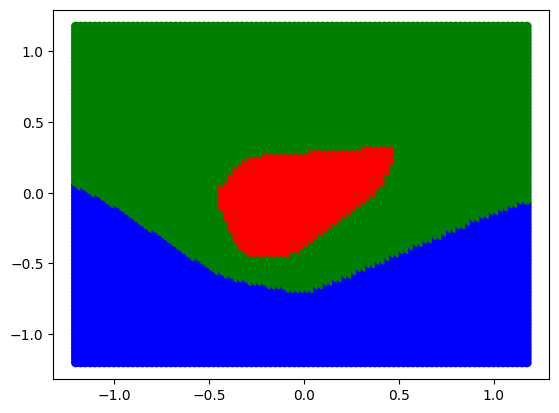

In [18]:
x = np.arange(-1.2, 1.2, 0.025)
combs = np.array(list(product(x, x)))

class test_dataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :]

comb_loader = DataLoader(dataset=test_dataset(combs))

Y_pred = []
for d in comb_loader:
    Y_pred.append(np.argmax(torch.squeeze(model(d), dim=0).tolist()))

colors = []
for val in Y_pred:
    if val == 0:
        colors.append('red')
    elif val == 1:
        colors.append('green')
    else:
        colors.append('blue')

plt.scatter(combs[:,0], combs[:,1], color=colors)


## Задание 2

Использовать многослойную нейронную сеть для аппроксимации функции. Произвести
обучение с помощью одного из методов первого порядка.

Посторим график представленной нам функции.

350


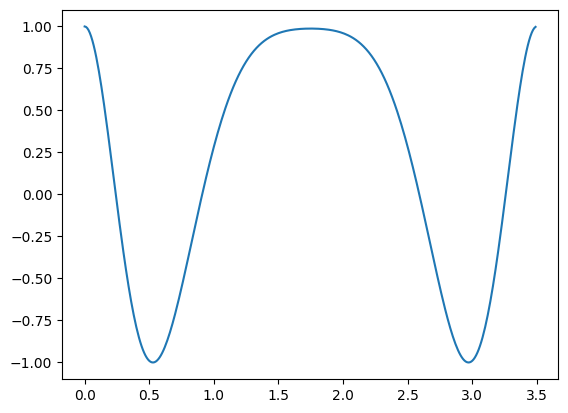

In [ ]:
h = 0.01
t = np.arange(0, 3.5, h)
x = np.cos( (-2) * t ** 2 + 7 * t)
plt.plot(t, x)
print(len(t))


Разбиваем данные на тренироваочные и тестовые.
Построим график.

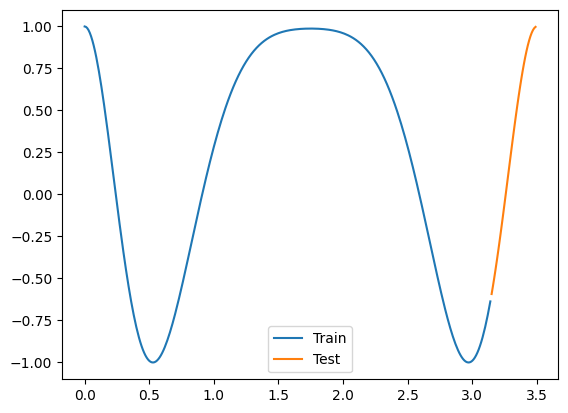

In [ ]:
train_size = int(len(t) * 0.9)

X_train = t[:train_size]
y_train = x[:train_size]
plt.plot(X_train, y_train, label='Train')

X_test = t[train_size:]
y_test = x[train_size:]

plt.plot(X_test, y_test, label = 'Test')
plt.legend()
plt.show()

Обучим модель. В качестве алгоритма обучения возьмем Adam (метод оптимизации 1 порядка)

In [ ]:
# Создание более глубокой модели
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model3 = Model()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

for epoch in range(600):
    optimizer.zero_grad()
    outputs = model3(X_train.view(-1, 1))
    loss = loss_func(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()


Как можно заметить модель хорошо справилась с обучающей выборкрой, но совсем плохо с тестовой.

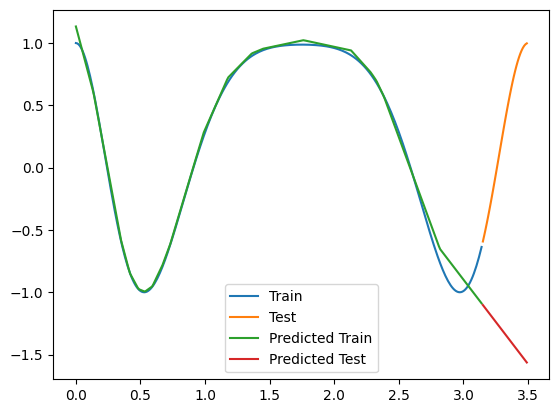

RMSE на обучающем наборе = 0.06667038798332214
RMSE на тестовом наборе = 1.7682040398792123


In [ ]:
# Предсказание на обучающем наборе
y_pred_train = model3(X_train.view(-1, 1)).detach().numpy()

# Предсказание на тестовом наборе
y_pred_test = model3(X_test.view(-1, 1)).detach().numpy()

plt.plot(X_train, y_train, label='Train')
plt.plot(X_test, y_test, label='Test')

plt.plot(X_train, y_pred_train, label='Predicted Train')
plt.plot(X_test, y_pred_test, label='Predicted Test')

plt.legend()
plt.show()

# Вычисление и вывод RMSE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'RMSE на обучающем наборе = {np.sqrt(mse_train)}')
print(f'RMSE на тестовом наборе = {np.sqrt(mse_test)}')


## Задание 3
Использовать многослойную нейронную сеть для аппроксимации функции. Произвести
обучение с помощью одного из методов второго порядка.

350


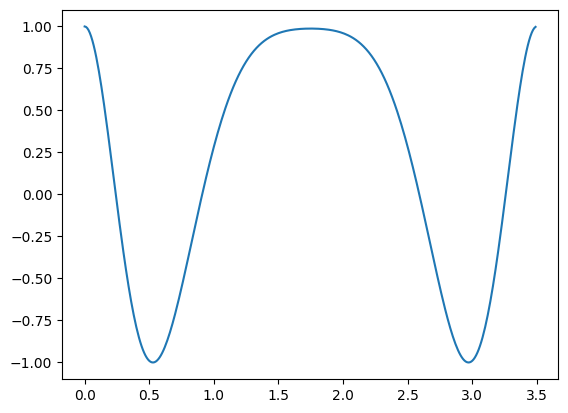

In [ ]:
h = 0.01
t = np.arange(0, 3.5, h)
x = np.cos( (-2) * t ** 2 + 7 * t)

plt.plot(t, x)
print(len(t))

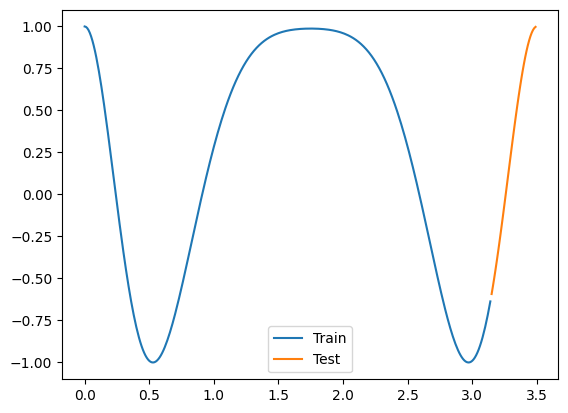

In [ ]:
train_size = int(len(t) * 0.9)

X_train = t[:train_size]
y_train = x[:train_size]
plt.plot(X_train, y_train, label='Train')

X_test = t[train_size:]
y_test = x[train_size:]

plt.plot(X_test, y_test, label = 'Test')
plt.legend()
plt.show()

Так как в Pytorch нет методов оптимизации второго порядка, то перейдем на PyTorch-Ipopt.

Ipopt - это библиотека для численной оптимизации, которая предоставляет эффективные методы оптимизации внутренних точек для различных задач оптимизации, включая задачи линейного и нелинейного программирования.

PyTorch-Ipopt - это обертка для библиотеки Ipopt, которая позволяет использовать Ipopt в среде PyTorch для оптимизации функций и моделей, представленных в виде вычислительных графов PyTorch.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)
        self.fc2 = torch.nn.Linear(10, 5)
        self.fc3 = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

In [ ]:
def train(x, y):
    def closure():
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        return loss
    optimizer.step(closure)

def predict(x):
    with torch.no_grad():
        model.eval()
        y_pred = model(x)
        return y_pred

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

In [ ]:
for epoch in range(600):
    train(X_train, y_train)


In [ ]:
X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1)
y_pred_train = predict(X_train).numpy()
y_pred_test = predict(X_test).numpy()

<ipython-input-50-467f55086a9d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).view(-1, 1)


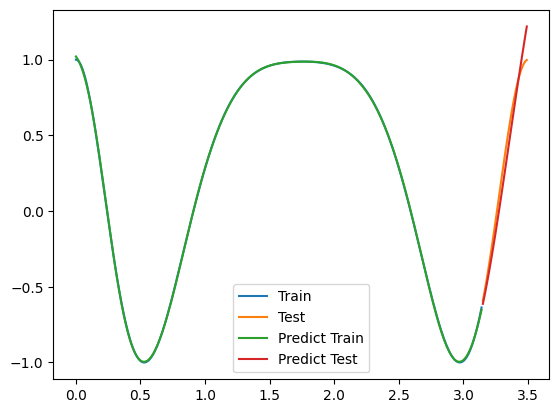

RMSE на обучающем наборе = 0.0038943032268434763
RMSE на тестовом наборе = 0.76273945325159


In [ ]:
plt.plot(X_train, y_train, label='Train')
plt.plot(X_test, y_test, label='Test')
plt.plot(X_train, y_pred_train, label='Predict Train')
plt.plot(X_test, y_pred_test, label='Predict Test')
plt.legend()
plt.show()

mse_train = ((y_train - y_pred_train) ** 2).mean()
mse_test = ((y_test - y_pred_test) ** 2).mean()
print(f'RMSE на обучающем наборе = {np.sqrt(mse_train)}')
print(f'RMSE на тестовом наборе = {np.sqrt(mse_test)}')

Как можно заметить у нас хорошо обучилась что и обучающая, что и тестовая выборка.

## Вывод

Данной лабораторной работе было изучено построеное многослойной модели на PyTorch. Данные были разбиты на обучающую, валидативную и тестовую выобрку, можно заметить что моя обучающая модель неплохо классифицирует классы.

Далее было предложено апроксимировать функции с помощью метода оптимизации первого порядка и второго.

Для первого  использовала метод Adam, где функция была поделина на обучающую и тестовую, после обучения модели вышло так, что тренировачная часть очень хорошо обучиласб, а тестовая вообще нет.

Для второго метода был использоан метод оптимизации L-BFGS(Квазиньютоновский метод), с помощью него модель обучилась дастаточно хорошо, что тренировочные и тестовые данные совпали достаточно точно.